In [4]:
import gt4py as gt
from gt4py import gtscript
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
mpl.rcParams["font.size"] = 16

In [5]:
#Compute x staggered
@gtscript.function
def xMid(dx, dt, h, hu):
    return 0.5 * (h[1, 0,0] + h[0,0,0]) - 0.5 * dt / dx[0,0,0] * (hu[1,0,0] - hu[0,0,0])

@gtscript.function
def yMid(dy1, dt, h, hv1):
    return 0.5 * (h[0,1,0] + h[0,0,0]) - 0.5 * dt / dy1[0,0,0] * (hv1[0,1,0] - hv1[0,0,0])

@gtscript.function
def xMid_hu(dx, dt, hu, hv, Ux, f, u, tgMidx, a):
    return (0.5 * (hu[1, 0,0] + hu[0,0,0]) - 0.5 * dt / dx[0,0,0] * (Ux[1,0,0] - Ux[0,0,0]) + \
            0.5 * dt * \
            (0.5 * (f[1,0,0] + f[0,0,0]) + \
            0.5 * (u[1,0,0] + u[0,0,0]) * tgMidx / a) * \
            (0.5 * (hv[1,0,0] + hv[0,0,0])))           

@gtscript.function
def yMid_hu(dy1, dt, hu, hv, Uy, f, u, tgMidy, a):
    return (0.5 * (hu[0,1,0] + hu[0,0,0]) - 0.5 * dt / dy1[0,0,0] * (Uy[0,1,0] - Uy[0,0,0]) + \
        0.5 * dt * \
        (0.5 * (f[0,1,0] + f[0,0,0]) + \
        0.5 * (u[0,1,0] + u[0,0,0]) * tgMidy / a) * \
        (0.5 * (hv[0,1,0] + hv[0,0,0])))

            
@gtscript.function
def xMid_hv(dx, dt, hu, hv, Vx, f, u, tgMidx, a):
    return (0.5 * (hv[1, 0,0] + hv[0,0,0]) - 0.5 * dt / dx[0,0,0] * (Vx[1,0,0] - Vx[0,0,0]) - \
            0.5 * dt * \
            (0.5 * (f[1,0,0] + f[0,0,0]) + \
            0.5 * (u[1,0,0] + u[0,0,0]) * tgMidx / a) * \
            (0.5 * (hu[1,0,0] + hu[0,0,0])))    
            
            
@gtscript.function
def yMid_hv(dy1, dy, dt, hu, hv,  Vy1, Vy2, f, u, tgMidy, a):
    return (0.5 * (hv[0,1,0] + hv[0,0,0]) \
            - 0.5 * dt / dy1[0,0,0] * (Vy1[0,1,0] - Vy1[0,0,0]) -  \
            0.5 * dt / dy[0,0,0] * (Vy2[0,1,0] - Vy2[0,0,0]) -\
            0.5 * dt * \
            (0.5 * (f[0,1,0] + f[0,0,0]) + \
            0.5 * (u[0,1,0] + u[0,0,0]) * tgMidy / a) * \
            (0.5 * (hu[0,1,0] + hu[0,0,0])))


def compute_temp_variables(
    u: gtscript.Field[float], 
    v: gtscript.Field[float],
    h: gtscript.Field[float],
    c: gtscript.Field[float],

    hu: gtscript.Field[float],
    hv: gtscript.Field[float],
    v1: gtscript.Field[float]):
    
    with computation(PARALLEL), interval(...):
        hu = h * u
        v1 = v * c
        hv = h * v

    
def x_staggered_first_step(
    u: gtscript.Field[float], 
    v: gtscript.Field[float],
    h: gtscript.Field[float],
    
    hu: gtscript.Field[float],
    hv: gtscript.Field[float],
    f: gtscript.Field[float],
    
    dx: gtscript.Field[float],
    tgMidx: gtscript.Field[float],
    
    hMidx: gtscript.Field[float],
    huMidx: gtscript.Field[float],
    hvMidx: gtscript.Field[float],
    *,
    dt: float,
    g: float,
    a: float):
    from __gtscript__ import PARALLEL, computation, interval
    from __externals__ import xMid, yMid, xMid_hu, yMid_hu, xMid_hv, yMid_hv
    
    with computation(PARALLEL), interval(...):
            Ux = hu * u + 0.5 * g * h * h
            Vx = hu * v
            
            # Mid-point value for h along x
            hMidx = xMid(dx, h, hu, dt)
            huMidx = xMid_hu(dx, dt, hu, hv, Ux, f, u, tgMidx, a)
            hvMidx = xMid_hv(dx, dt, hu, hv, Vx, f, u, tgMidx, a)
    

def y_staggered_first_step(
    u: gtscript.Field[float], 
    v: gtscript.Field[float],
    h: gtscript.Field[float],
    
    hu: gtscript.Field[float],
    hv: gtscript.Field[float],
    v1: gtscript.Field[float],
    f: gtscript.Field[float],
    
    dy: gtscript.Field[float],
    dy1: gtscript.Field[float],
    tgMidy: gtscript.Field[float],
    
    hMidy: gtscript.Field[float],
    huMidy: gtscript.Field[float],
    hvMidy: gtscript.Field[float],   
    *,
    dt: float,
    g: float,
    a: float):
    from __gtscript__ import PARALLEL, computation, interval
    from __externals__ import xMid, yMid, xMid_hu, yMid_hu, xMid_hv, yMid_hv
    
    with computation(PARALLEL), interval(...):
            hv1 = h * v1
            Uy = hu * v1
            Vy1 = hv * v1
            Vy2 = 0.5 * g * h * h
        
            # Mid-point value for h along y
            hMidy = yMid(dy1, h, hv1, dt)
            huMidy = yMid_hu(dy1, dt, hu, hv, Uy, f, u, tgMidy, a)
            hvMidy = yMid_hv(dy1, dy, dt, hu, hv,  Vy1, Vy2, f, u, tgMidy, a)


            

In [6]:
@gtscript.function
def compute_hnew(h, dt, dxc, huMidx, dy1c, hvMidy, cMidy):
    return h[1,1,0] -  dt / dxc[0,0,0] * (huMidx[1,0,0] - huMidx[0,0,0]) - dt /dy1c[0,0,0] * (hvMidy[0,1,0]*cMidy[0,1,0] - hvMidy[0,0,0]*cMidy[0,0,0])

@gtscript.function
def compute_hunew(hu, dt, dxc, UxMid, dy1c, UyMid, f, huMidx, hMidx, huMidy,hMidy,tg, a, hvMidx,hvMidy,g, hs,dx):
    first= dt / dxc * (UxMid[1,0,0] - UxMid[0,0,0])
    
    second= dt / dy1c * (UyMid[0,1,0] - UyMid[0,0,0])
    
    third= dt * (f[1,1,0] +  0.25 * (huMidx[0,0,0] / hMidx[0,0,0] + \
                                    huMidx[1,0,0] / hMidx[1,0,0] + \
                                    huMidy[0,0,0] / hMidy[0,0,0] + \
                                    huMidy[0,1,0] / hMidy[0,1,0]) * \
                                    tg /a) * \
                                    0.25 * (hvMidx[0,0,0] + hvMidx[1,0,0] + hvMidy[0,0,0] + hvMidy[0,1,0])
    
    fourth= dt * g * 0.25 * (hMidx[0,0,0] + hMidx[1,0,0] + hMidy[0,0,0] + hMidy[0,1,0]) * \
                (hs[2,0,0] - hs[0,0,0]) / (dx[0,0,0] + dx[1,0,0])
    
    return hu[1,1,0] - first - second + third - fourth
    

@gtscript.function
def compute_hvnew(hv, dt, dxc, VxMid, dy1c, Vy1Mid, dyc, Vy2Mid, f, huMidx, hMidx, huMidy, hMidy, tg, a, g, hs, dy1):
    
    first  = dt / dxc * (VxMid[1,0,0] - VxMid[0,0,0])
    second = dt / dy1c * (Vy1Mid[0,1,0] - Vy1Mid[0,0,0])
    third  = dt / dyc * (Vy2Mid[0,1,0] - Vy2Mid[0,0,0])
    
    fourth = dt * (f[0,0,0] + 0.25 * (huMidx[0,0,0] / hMidx[0,0,0] + \
                                    huMidx[1,0,0] / hMidx[1,0,0] + \
                                    huMidy[0,0,0] / hMidy[0,0,0] + \
                                    huMidy[0,1,0] / hMidy[0,1,0]) * \
                                    tg / a) * \
                                    0.25 * (huMidx[0,0,0] + huMidx[1,0,0] + huMidy[0,0,0] + huMidy[0,1,0])
                  
    fifth  = dt * g * 0.25 * (hMidx[0,0,0] + hMidx[1,0,0] + hMidy[0,0,0] + hMidy[0,1,0]) * (hs[1,2,0] - hs[1,0,0]) / (dy1[1,1,0] + dy1[1,0,0]) 
    
    return hv[1,1,0] - first - second - third - fourth - fifth

In [7]:
def combined_last_step(
    h: gtscript.Field[float], 
    
    hu: gtscript.Field[float],
    hv: gtscript.Field[float],
    hs: gtscript.Field[float],
    
    f: gtscript.Field[float],
    tg: gtscript.Field[float],
    
    huMidx: gtscript.Field[float],
    huMidy: gtscript.Field[float],
    hvMidx: gtscript.Field[float],
    hvMidy: gtscript.Field[float],
    hMidx: gtscript.Field[float],
    hMidy: gtscript.Field[float],
    cMidy: gtscript.Field[float],
    
    dx: gtscript.Field[float],
    dy1: gtscript.Field[float],
    dxc: gtscript.Field[float],
    dyc: gtscript.Field[float],
    dy1c: gtscript.Field[float],
    
    hnew: gtscript.Field[float],
    unew: gtscript.Field[float],
    vnew: gtscript.Field[float],
    *,
    dt: float,
    g: float,
    a: float):
    from __gtscript__ import PARALLEL, computation, interval
    from __externals__ import compute_hnew, compute_hunew, compute_hvnew
    
    with computation(PARALLEL), interval(...):
        # Update fluid height
        hnew=compute_hnew(h, dt, dxc, huMidx, dy1c, hvMidy, cMidy)
        
        # Update longitudinal moment
        
        #---RECPLACED NUMPY WHERE----------------------------------------
        temp_bool=hMidx > 0.0        
        UxMid = temp_bool* (huMidx * huMidx / hMidx + 0.5 * g * hMidx * hMidx)
        temp_bool=hMidx <= 0.0
        UxMid=UxMid +  temp_bool*(0.5 * g * hMidx * hMidx)
        
        temp_bool=hMidy > 0.0        
        UyMid = temp_bool* (hvMidy * cMidy * huMidy / hMidy)
        #---RECPLACED NUMPY WHERE----------------------------------------
        
        hunew = compute_hunew(hu, dt, dxc, UxMid, dy1c, UyMid, f, huMidx, hMidx, huMidy,hMidy,tg, a, hvMidx,hvMidy,g, hs,dx)
            
        
        #---RECPLACED NUMPY WHERE----------------------------------------
        
        # Update latitudinal moment
        temp_bool=hMidx > 0.0
        VxMid = temp_bool * (hvMidx * huMidx / hMidx)
                            
        temp_bool=hMidy > 0.0
        Vy1Mid = temp_bool * (hvMidy * hvMidy / hMidy * cMidy)
        
        Vy2Mid = 0.5 * g * hMidy * hMidy
        #---RECPLACED NUMPY WHERE----------------------------------------
 
        hvnew = compute_hvnew(hv, dt, dxc, VxMid, dy1c, Vy1Mid, dyc, Vy2Mid, f, huMidx, hMidx, huMidy, hMidy, tg, a, g, hs, dy1) #Klopt dit laatste?
        
        
        # Come back to original variables
        unew = hunew / hnew
        vnew = hvnew / hnew

In [8]:
backend="numpy"
temp_variables = gtscript.stencil(definition=compute_temp_variables, backend=backend)
x_staggered = gtscript.stencil(definition=x_staggered_first_step, backend=backend, externals={"xMid": xMid, "yMid": yMid, "xMid_hu": xMid_hu, "yMid_hu": yMid_hu, "xMid_hv": xMid_hv, "yMid_hv": yMid_hv})
y_staggered = gtscript.stencil(definition=y_staggered_first_step, backend=backend, externals={"xMid": xMid, "yMid": yMid, "xMid_hu": xMid_hu, "yMid_hu": yMid_hu, "xMid_hv": xMid_hv, "yMid_hv": yMid_hv})
combined = gtscript.stencil(definition=combined_last_step, backend=backend, externals={"compute_hnew":compute_hnew, "compute_hunew":compute_hunew, "compute_hvnew":compute_hvnew})

In [17]:
a=np.zeros((2,3))

In [19]:
np.shape(np.expand_dims(a,axis=2))

(2, 3, 1)

In [68]:
# grid size
nx = 10
ny = 10
nz=1

# storage shape
shape = (nx, ny, nz)
default_shape = (nx-2,ny-2,nz)
shape_staggered_x = (nx-1, ny, nz)
shape_staggered_y = (nx, ny-1, nz)

# default origin (trust it for now!)
default_origin = (0, 0, 0)
origin_staggered = (0,0,0)

In [69]:
#TEST TEMP VARIABLES:
u = gt.storage.ones(backend, default_origin, shape, dtype=float)
v = gt.storage.ones(backend, default_origin, shape, dtype=float)
h = gt.storage.ones(backend, default_origin, shape, dtype=float)
c = gt.storage.ones(backend, default_origin, shape, dtype=float)

hu=gt.storage.empty(backend, default_origin, shape, dtype=float)
hv=gt.storage.empty(backend, default_origin, shape, dtype=float)
v1=gt.storage.empty(backend, default_origin, shape, dtype=float)

temp_variables(u,v,h,c,hu,hv,v1, origin=default_origin, domain=shape)

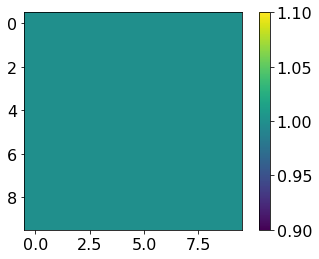

In [70]:
plt.imshow(np.asarray(v1))
plt.colorbar()

In [71]:
#TEST X_STAGGERED
dx=gt.storage.ones(backend, default_origin, shape_staggered_x, dtype=float)
tgMidx=gt.storage.ones(backend, default_origin, shape_staggered_x, dtype=float)

f = gt.storage.ones(backend, default_origin, shape, dtype=float)

hMidx=gt.storage.empty(backend, default_origin, shape_staggered_x, dtype=float)
huMidx=gt.storage.empty(backend, default_origin, shape_staggered_x, dtype=float)
hvMidx=gt.storage.empty(backend, default_origin, shape_staggered_x, dtype=float)

dt=1.0
g=9.81
a=1.0

x_staggered(u=u,v=v,h=h,hu=hu,hv=hv,f=f,dx=dx,tgMidx=tgMidx,hMidx=hMidx,huMidx=huMidx,hvMidx=hvMidx,dt=dt,g=g,a=a, origin=default_origin, domain=shape_staggered_x)

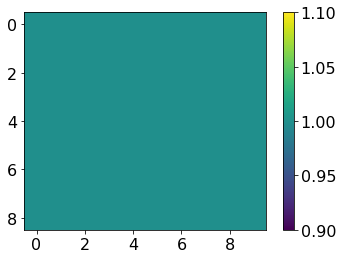

In [72]:
plt.imshow(np.asarray(hMidx))
plt.colorbar()

In [73]:
#TEST Y_STAGGERED
dy=gt.storage.ones(backend, default_origin, shape_staggered_y, dtype=float)
dy1=gt.storage.ones(backend, default_origin, shape_staggered_y, dtype=float)
tgMidy=gt.storage.ones(backend, default_origin, shape_staggered_y, dtype=float)

hMidy=gt.storage.empty(backend, default_origin, shape_staggered_y, dtype=float)
huMidy=gt.storage.empty(backend, default_origin, shape_staggered_y, dtype=float)
hvMidy=gt.storage.empty(backend, default_origin, shape_staggered_y, dtype=float)

y_staggered(u=u,v=v,h=h,hu=hu,hv=hv,v1=v1,f=f,dy=dy,dy1=dy1,tgMidy=tgMidy,hMidy=hMidy,huMidy=huMidy,hvMidy=hvMidy,dt=dt,g=g,a=a, origin=default_origin, domain=shape_staggered_y)

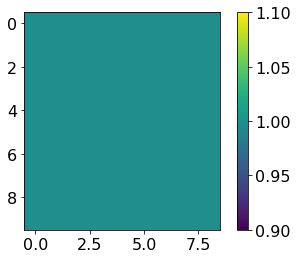

In [74]:
plt.imshow(np.asarray(hMidy))
plt.colorbar()

In [75]:
hs=gt.storage.ones(backend, default_origin, shape, dtype=float)
tg=gt.storage.ones(backend, default_origin, shape, dtype=float)

cMidy=gt.storage.ones(backend, default_origin, shape_staggered_y, dtype=float)

dxc=gt.storage.ones(backend, default_origin, default_shape, dtype=float)
dyc=gt.storage.ones(backend, default_origin, default_shape, dtype=float)
dy1c=gt.storage.ones(backend, default_origin, default_shape, dtype=float)

hnew =gt.storage.empty(backend, default_origin, default_shape, dtype=float)
unew =gt.storage.empty(backend, default_origin, default_shape, dtype=float)
vnew =gt.storage.empty(backend, default_origin, default_shape, dtype=float)

In [76]:
combined(h=h,hu=hu, hv=hv, hs=hs, f=f, tg=tg, huMidx=huMidx, huMidy=huMidy, hvMidx=hvMidx, \
         hvMidy=hvMidy,hMidx=hMidx, hMidy=hMidy,cMidy=cMidy, dx=dx, dy1=dy1,dxc=dxc,dyc=dyc,dy1c=dy1c,\
         hnew=hnew, unew=unew, vnew=vnew, \
         dt=dt, g=g, a=a, origin=(0,0,0), domain=default_shape)

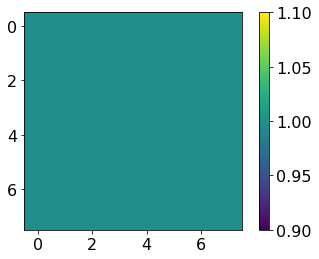

In [77]:
plt.imshow(np.asarray(hnew))
plt.colorbar()

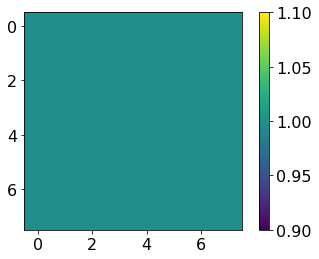

In [78]:
plt.imshow(np.asarray(unew))
plt.colorbar()

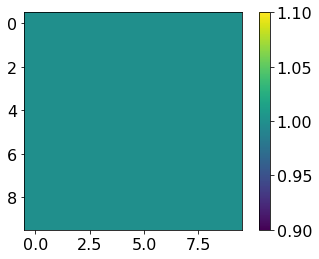

In [79]:
plt.imshow(np.asarray(hs))
plt.colorbar()

In [49]:
temp_bool=hMidx > 0.0
UxMid = temp_bool* (huMidx * huMidx / hMidx + 0.5 * g * hMidx * hMidx)

In [53]:
temp_bool=hMidx <= 0.0
UxMid=UxMid +  temp_bool*(0.5 * g * hMidx * hMidx)

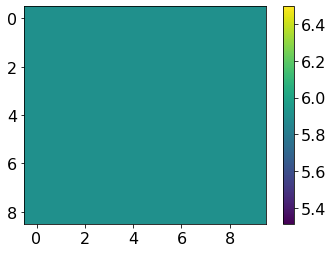

In [55]:
plt.imshow(np.asarray(UxMid))
plt.colorbar()

In [56]:
plt.imshow(compute_hunew(hu, dt, dxc, UxMid, dy1c, UyMid, f, huMidx, hMidx, huMidy,hMidy,tg, a, hvMidx,hvMidy,g, hs,dx))
plt.colorbar()



NameError: name 'UyMid' is not defined

In [61]:
temp_bool=hMidy > 0.0        
UyMid = 0+temp_bool* (hvMidy * cMidy * huMidy / hMidy)

/tmp/ipykernel_13657/133588567.py:2: RuntimeWarning: divide by zero encountered in divide
  UyMid = 0+temp_bool* (hvMidy * cMidy * huMidy / hMidy)
/tmp/ipykernel_13657/133588567.py:2: RuntimeWarning: invalid value encountered in multiply
  UyMid = 0+temp_bool* (hvMidy * cMidy * huMidy / hMidy)


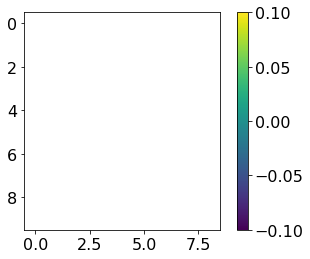

In [62]:
plt.imshow(np.asarray(UyMid))
plt.colorbar()

In [9]:
#Compute x staggered
@gtscript.function
def xMid(self, dx, dt, h, hu):
    return 0.5 * (h[1, 0,0] + h[0,0,0]) - 0.5 * dt / dx[0,0,0] * (hu[1,0,0] - hu[0,0,0])

@gtscript.function
def yMid(self, dy1, dt, h, hv1):
    return 0.5 * (h[0,1,0] + h[0,0,0]) - 0.5 * dt / dy1[0,0,0] * (hv1[0,1,0] - hv1[0,0,0])

@gtscript.function
def xMid_hu(self, dx, dt, hu, hv, Ux, f, u, tgMidx, a):
    return (0.5 * (hu[1, 0,0] + hu[0,0,0]) - 0.5 * dt / dx[0,0,0] * (Ux[1,0,0] - Ux[0,0,0]) + \
            0.5 * dt * \
            (0.5 * (f[1,0,0] + f[0,0,0]) + \
            0.5 * (u[1,0,0] + u[0,0,0]) * tgMidx / a) * \
            (0.5 * (hv[1,0,0] + hv[0,0,0])))           

@gtscript.function
def yMid_hu(self, dy1, dt, hu, hv, Uy, f, u, tgMidy, a):
    return (0.5 * (hu[0,1,0] + hu[0,0,0]) - 0.5 * dt / dy1[0,0,0] * (Uy[0,1,0] - Uy[0,0,0]) + \
        0.5 * dt * \
        (0.5 * (f[0,1,0] + f[0,0,0]) + \
        0.5 * (u[0,1,0] + u[0,0,0]) * tgMidy / a) * \
        (0.5 * (hv[0,1,0] + hv[0,0,0])))


@gtscript.function
def xMid_hv(self, dx, dt, hu, hv, Vx, f, u, tgMidx, a):
    return (0.5 * (hv[1, 0,0] + hv[0,0,0]) - 0.5 * dt / dx[0,0,0] * (Vx[1,0,0] - Vx[0,0,0]) - \
            0.5 * dt * \
            (0.5 * (f[1,0,0] + f[0,0,0]) + \
            0.5 * (u[1,0,0] + u[0,0,0]) * tgMidx / a) * \
            (0.5 * (hu[1,0,0] + hu[0,0,0])))    


@gtscript.function
def yMid_hv(self, dy1, dy, dt, hu, hv,  Vy1, Vy2, f, u, tgMidy, a):
    return (0.5 * (hv[0,1,0] + hv[0,0,0]) \
            - 0.5 * dt / dy1[0,0,0] * (Vy1[0,1,0] - Vy1[0,0,0]) -  \
            0.5 * dt / dy[0,0,0] * (Vy2[0,1,0] - Vy2[0,0,0]) -\
            0.5 * dt * \
            (0.5 * (f[0,1,0] + f[0,0,0]) + \
            0.5 * (u[0,1,0] + u[0,0,0]) * tgMidy / a) * \
            (0.5 * (hu[0,1,0] + hu[0,0,0])))

@gtscript.function
def compute_hnew(h, dt, dxc, huMidx, dy1c, hvMidy, cMidy):
    return h[1,1,0] -  dt / dxc[0,0,0] * (huMidx[1,0,0] - huMidx[0,0,0]) - dt /dy1c[0,0,0] * (hvMidy[0,1,0]*cMidy[0,1,0] - hvMidy[0,0,0]*cMidy[0,0,0])

@gtscript.function
def compute_hunew(hu, dt, dxc, UxMid, dy1c, UyMid, f, huMidx, hMidx, huMidy,hMidy,tg, a, hvMidx,hvMidy,g, hs,dx):
    first= dt / dxc * (UxMid[1,0,0] - UxMid[0,0,0])

    second= dt / dy1c * (UyMid[0,1,0] - UyMid[0,0,0])

    third= dt * (f[1,1,0] +  0.25 * (huMidx[0,0,0] / hMidx[0,0,0] + \
                                    huMidx[1,0,0] / hMidx[1,0,0] + \
                                    huMidy[0,0,0] / hMidy[0,0,0] + \
                                    huMidy[0,1,0] / hMidy[0,1,0]) * \
                                    tg /a) * \
                                    0.25 * (hvMidx[0,0,0] + hvMidx[1,0,0] + hvMidy[0,0,0] + hvMidy[0,1,0])

    fourth= dt * g * 0.25 * (hMidx[0,0,0] + hMidx[1,0,0] + hMidy[0,0,0] + hMidy[0,1,0]) * \
                (hs[2,0,0] - hs[0,0,0]) / (dx[0,0,0] + dx[1,0,0])

    return hu[1,1,0] - first - second + third - fourth


@gtscript.function
def compute_hvnew(hv, dt, dxc, VxMid, dy1c, Vy1Mid, dyc, Vy2Mid, f, huMidx, hMidx, huMidy, hMidy, tg, a, g, hs, dy1):

    first  = dt / dxc * (VxMid[1,0,0] - VxMid[0,0,0])
    second = dt / dy1c * (Vy1Mid[0,1,0] - Vy1Mid[0,0,0])
    third  = dt / dyc * (Vy2Mid[0,1,0] - Vy2Mid[0,0,0])

    fourth = dt * (f[0,0,0] + 0.25 * (huMidx[0,0,0] / hMidx[0,0,0] + \
                                    huMidx[1,0,0] / hMidx[1,0,0] + \
                                    huMidy[0,0,0] / hMidy[0,0,0] + \
                                    huMidy[0,1,0] / hMidy[0,1,0]) * \
                                    tg / a) * \
                                    0.25 * (huMidx[0,0,0] + huMidx[1,0,0] + huMidy[0,0,0] + huMidy[0,1,0])

    fifth  = dt * g * 0.25 * (hMidx[0,0,0] + hMidx[1,0,0] + hMidy[0,0,0] + hMidy[0,1,0]) * (hs[1,2,0] - hs[1,0,0]) / (dy1[1,1,0] + dy1[1,0,0]) 

    return hv[1,1,0] - first - second - third - fourth - fifth

def compute_temp_variables(
    u: gtscript.Field[float], 
    v: gtscript.Field[float],
    h: gtscript.Field[float],
    c: gtscript.Field[float],

    hu: gtscript.Field[float],
    hv: gtscript.Field[float],
    v1: gtscript.Field[float]):

    with computation(PARALLEL), interval(...):
        hu = h * u
        v1 = v * c
        hv = h * v
        
def x_staggered_first_step(
    u: gtscript.Field[float], 
    v: gtscript.Field[float],
    h: gtscript.Field[float],
    
    hu: gtscript.Field[float],
    hv: gtscript.Field[float],
    f: gtscript.Field[float],
    
    dx: gtscript.Field[float],
    tgMidx: gtscript.Field[float],
    
    hMidx: gtscript.Field[float],
    huMidx: gtscript.Field[float],
    hvMidx: gtscript.Field[float],
    *,
    dt: float,
    g: float,
    a: float):
    from __gtscript__ import PARALLEL, computation, interval
    from __externals__ import xMid, yMid, xMid_hu, yMid_hu, xMid_hv, yMid_hv
    
    with computation(PARALLEL), interval(...):
            Ux = hu * u + 0.5 * g * h * h
            Vx = hu * v
            
            # Mid-point value for h along x
            hMidx = xMid(dx, h, hu, dt)
            huMidx = xMid_hu(dx, dt, hu, hv, Ux, f, u, tgMidx, a)
            hvMidx = xMid_hv(dx, dt, hu, hv, Vx, f, u, tgMidx, a)


print("Test")
backend="numpy"
x_staggered = gtscript.stencil(definition=x_staggered_first_step, backend=backend, externals={"xMid":xMid, "yMid":yMid, "xMid_hu":xMid_hu, "yMid_hu":yMid_hu, "xMid_hv":xMid_hv, "yMid_hv":yMid_hv}, rebuild=False)

Test


GTScriptSyntaxError: Invalid call signature

In [10]:
#Compute x staggered
@gtscript.function
def xMid(dx, dt, h, hu):
    return 0.5 * (h[1, 0,0] + h[0,0,0]) - 0.5 * dt / dx[0,0,0] * (hu[1,0,0] - hu[0,0,0])

@gtscript.function
def yMid(dy1, dt, h, hv1):
    return 0.5 * (h[0,1,0] + h[0,0,0]) - 0.5 * dt / dy1[0,0,0] * (hv1[0,1,0] - hv1[0,0,0])

@gtscript.function
def xMid_hu(dx, dt, hu, hv, Ux, f, u, tgMidx, a):
    return (0.5 * (hu[1, 0,0] + hu[0,0,0]) - 0.5 * dt / dx[0,0,0] * (Ux[1,0,0] - Ux[0,0,0]) + \
            0.5 * dt * \
            (0.5 * (f[1,0,0] + f[0,0,0]) + \
            0.5 * (u[1,0,0] + u[0,0,0]) * tgMidx / a) * \
            (0.5 * (hv[1,0,0] + hv[0,0,0])))           

@gtscript.function
def yMid_hu(dy1, dt, hu, hv, Uy, f, u, tgMidy, a):
    return (0.5 * (hu[0,1,0] + hu[0,0,0]) - 0.5 * dt / dy1[0,0,0] * (Uy[0,1,0] - Uy[0,0,0]) + \
        0.5 * dt * \
        (0.5 * (f[0,1,0] + f[0,0,0]) + \
        0.5 * (u[0,1,0] + u[0,0,0]) * tgMidy / a) * \
        (0.5 * (hv[0,1,0] + hv[0,0,0])))

            
@gtscript.function
def xMid_hv(dx, dt, hu, hv, Vx, f, u, tgMidx, a):
    return (0.5 * (hv[1, 0,0] + hv[0,0,0]) - 0.5 * dt / dx[0,0,0] * (Vx[1,0,0] - Vx[0,0,0]) - \
            0.5 * dt * \
            (0.5 * (f[1,0,0] + f[0,0,0]) + \
            0.5 * (u[1,0,0] + u[0,0,0]) * tgMidx / a) * \
            (0.5 * (hu[1,0,0] + hu[0,0,0])))    
            
            
@gtscript.function
def yMid_hv(dy1, dy, dt, hu, hv,  Vy1, Vy2, f, u, tgMidy, a):
    return (0.5 * (hv[0,1,0] + hv[0,0,0]) \
            - 0.5 * dt / dy1[0,0,0] * (Vy1[0,1,0] - Vy1[0,0,0]) -  \
            0.5 * dt / dy[0,0,0] * (Vy2[0,1,0] - Vy2[0,0,0]) -\
            0.5 * dt * \
            (0.5 * (f[0,1,0] + f[0,0,0]) + \
            0.5 * (u[0,1,0] + u[0,0,0]) * tgMidy / a) * \
            (0.5 * (hu[0,1,0] + hu[0,0,0])))


def compute_temp_variables(
    u: gtscript.Field[float], 
    v: gtscript.Field[float],
    h: gtscript.Field[float],
    c: gtscript.Field[float],

    hu: gtscript.Field[float],
    hv: gtscript.Field[float],
    v1: gtscript.Field[float]):
    
    with computation(PARALLEL), interval(...):
        hu = h * u
        v1 = v * c
        hv = h * v

    
def x_staggered_first_step(
    u: gtscript.Field[float], 
    v: gtscript.Field[float],
    h: gtscript.Field[float],
    
    hu: gtscript.Field[float],
    hv: gtscript.Field[float],
    f: gtscript.Field[float],
    
    dx: gtscript.Field[float],
    tgMidx: gtscript.Field[float],
    
    hMidx: gtscript.Field[float],
    huMidx: gtscript.Field[float],
    hvMidx: gtscript.Field[float],
    *,
    dt: float,
    g: float,
    a: float):
    from __gtscript__ import PARALLEL, computation, interval
    from __externals__ import xMid, yMid, xMid_hu, yMid_hu, xMid_hv, yMid_hv
    
    with computation(PARALLEL), interval(...):
            Ux = hu * u + 0.5 * g * h * h
            Vx = hu * v
            
            # Mid-point value for h along x
            hMidx = xMid(dx, h, hu, dt)
            huMidx = xMid_hu(dx, dt, hu, hv, Ux, f, u, tgMidx, a)
            hvMidx = xMid_hv(dx, dt, hu, hv, Vx, f, u, tgMidx, a)

In [11]:
x_staggered = gtscript.stencil(definition=x_staggered_first_step, backend=backend, externals={"xMid": xMid, "yMid": yMid, "xMid_hu": xMid_hu, "yMid_hu": yMid_hu, "xMid_hv": xMid_hv, "yMid_hv": yMid_hv})


In [23]:
np.shape(np.vstack((np.zeros(2), a)))

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 3